In [4]:
import pandas as pd

df = pd.read_csv("merged_train_with_features.csv")

# Check for missing values
null_counts = df.isnull().sum()
null_cols = null_counts[null_counts > 0]
print("Columns with NaNs:\n", null_cols)


Columns with NaNs:
 voltage_rise_time_pulse1    508
voltage_rise_time_pulse2    508
voltage_fall_time_pulse1    508
voltage_fall_time_pulse2    508
current_rise_time_pulse1    508
current_rise_time_pulse2    508
current_fall_time_pulse1    508
current_fall_time_pulse2    508
overshoot_pulse_1           508
overshoot_pulse_2           508
undershoot_pulse_1          508
undershoot_pulse_2          508
ringing_frequency_MHz       508
overshoot_norm_1            508
overshoot_norm_2            508
dtype: int64


In [8]:
df_clean = df.dropna()



Model Evaluation:
R² Score: -0.1696
RMSE: 28.983230
MAE: 9.192499

Top 20 Correlated Features with voltage_rise_time_pulse1:
Coss                 0.396354
Ciss                 0.396149
Qrr                  0.395585
Power_dissipation    0.394998
Qgs                  0.394947
Eon                  0.391311
Qg_total             0.388038
Irrm                 0.387509
Qrr_Irrm_ratio       0.387390
Qgd                  0.382560
td_off               0.378324
Rth_JC_typ           0.377686
Eoff                 0.377189
Rth_JC_max           0.374606
tr                   0.370387
Cgd_Ciss_ratio       0.367065
E_sw_est             0.365881
f_ring_est           0.365280
P_rr_est             0.363415
Crss                 0.359332
dtype: float64

Top 10 RFE Features:
['RDS_on_typ', 'Rg_int', 'Ciss', 'Coss', 'Qrr', 'Irrm', 'Rth_JC_typ', 'L_total', 'f_ring_est', 'overshoot_norm_2']

Lasso Selected Features:
[]


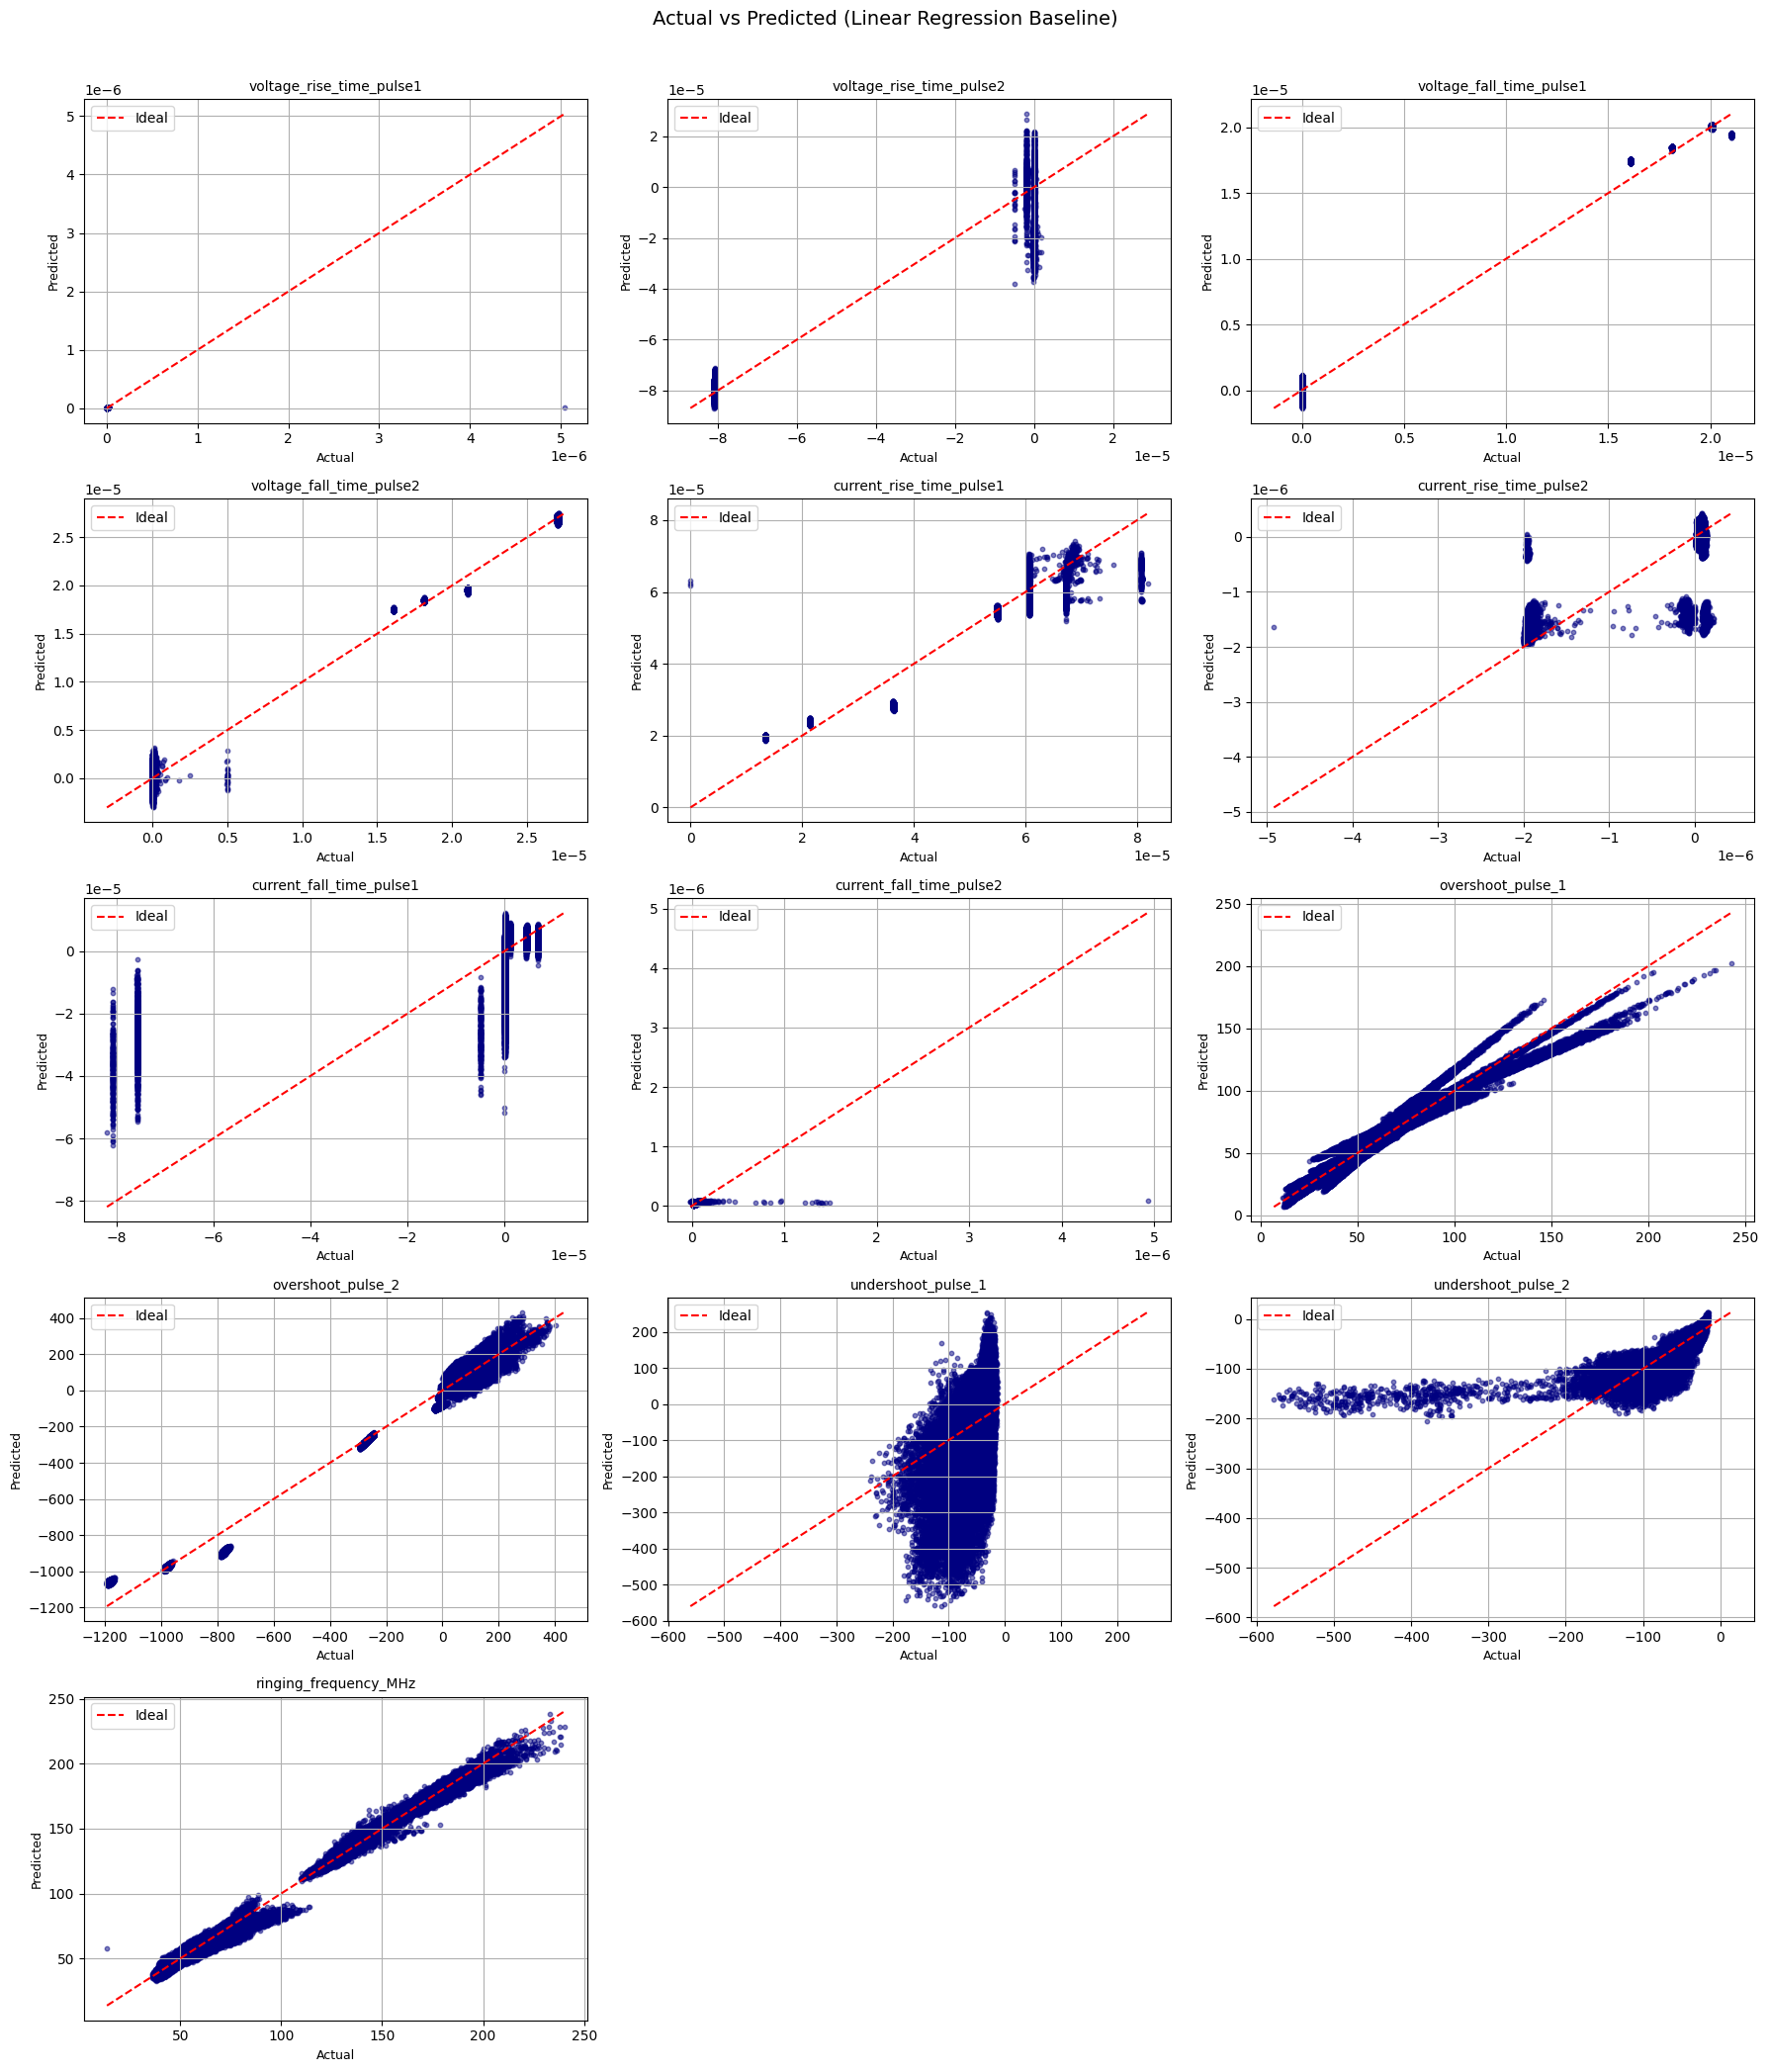

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# === LOAD AND CLEAN DATA ===
data = pd.read_csv("merged_train_with_features.csv")

# Drop rows with missing targets
target_cols = [
    'voltage_rise_time_pulse1', 'voltage_rise_time_pulse2',
    'voltage_fall_time_pulse1', 'voltage_fall_time_pulse2',
    'current_rise_time_pulse1', 'current_rise_time_pulse2',
    'current_fall_time_pulse1', 'current_fall_time_pulse2',
    'overshoot_pulse_1', 'overshoot_pulse_2',
    'undershoot_pulse_1', 'undershoot_pulse_2',
    'ringing_frequency_MHz'
]
data = data.dropna(subset=target_cols)

# === SPLIT FEATURES AND TARGETS ===
X = data.drop(columns=["DeviceID"] + target_cols)
y = data[target_cols]

# Impute NaNs in features with mean (safe and fast)
X = X.fillna(X.mean(numeric_only=True))

# === SCALING ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === TRAIN-TEST SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y.values, test_size=0.2, random_state=42
)

# === LINEAR REGRESSION MODEL ===
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# === EVALUATION METRICS ===
print(f"\nModel Evaluation:")
print(f"R² Score: {r2_score(y_test, y_pred, multioutput='uniform_average'):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.6f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.6f}")

# === FEATURE SELECTION ===
print("\nTop 20 Correlated Features with voltage_rise_time_pulse1:")
corr = pd.DataFrame(X_scaled, columns=X.columns).corrwith(y['voltage_rise_time_pulse1']).abs()
print(corr.sort_values(ascending=False).head(20))

rfe = RFE(LinearRegression(), n_features_to_select=10)
rfe.fit(X_scaled, y['voltage_rise_time_pulse1'])
print("\nTop 10 RFE Features:")
print(X.columns[rfe.support_].tolist())

lasso = LassoCV(cv=5).fit(X_scaled, y['voltage_rise_time_pulse1'])
lasso_features = X.columns[np.abs(lasso.coef_) > 1e-4]
print("\nLasso Selected Features:")
print(lasso_features.tolist())


# === PLOT ACTUAL vs PREDICTED ===
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 22))
axes = axes.flatten()

for i, col in enumerate(target_cols):
    ax = axes[i]
    ax.scatter(y_test[:, i], y_pred[:, i], alpha=0.5, color='navy', s=10)
    min_val = min(y_test[:, i].min(), y_pred[:, i].min())
    max_val = max(y_test[:, i].max(), y_pred[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal")
    ax.set_title(f"{col}", fontsize=10)
    ax.set_xlabel("Actual", fontsize=9)
    ax.set_ylabel("Predicted", fontsize=9)
    ax.grid(True)
    ax.legend()

# Hide extra subplot if any
for j in range(len(target_cols), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Actual vs Predicted (Linear Regression Baseline)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()
